# Brazilian E-commerce Demand Forecasting - Baseline Model

## **Business Objective**
Develop a baseline machine learning model to **forecast product demand 2 weeks ahead** for a Brazilian e-commerce platform, enabling optimal inventory management and reducing stockouts/overstock situations.

## **Technical Approach**
**Primary Model**: LightGBM Regressor - An efficient gradient boosting framework optimized for sparse data

## **Implementation Plan**

### Phase 1: Data Understanding & Exploration
- Load and inspect preprocessed daily demand data
- Analyze sparsity patterns and temporal trends
- Identify key data quality issues

### Phase 2: Feature Engineering
- **Temporal Features**: Day-of-week, month, quarter, weekend indicators
- **Lag Features**: Historical demand (1, 7, 30 days ago)
- **Rolling Features**: Moving averages and volatility measures
- **Target Creation**: 2-week ahead demand forecasting

### Phase 3: Model Development
- Train LightGBM with time series cross-validation
- Evaluate performance with appropriate metrics
- Generate predictions and business insights

##  **Key Technical Challenges**
- **Extreme Sparsity**: 99% zero demand values in daily data
- **Data Leakage Prevention**: Ensure features use only historical information
- **Time Series Structure**: Maintain temporal order in validation


In [9]:

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, GroupKFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from lightgbm import LGBMRegressor


# Configure visualization settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(" All libraries imported successfully!")
print(" Visualization settings configured")
print(" Machine learning tools ready")


 All libraries imported successfully!
 Visualization settings configured
 Machine learning tools ready


In [10]:

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, GroupKFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from lightgbm import LGBMRegressor


# Configure visualization settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(" All libraries imported successfully!")
print(" Visualization settings configured")
print(" Machine learning tools ready")


 All libraries imported successfully!
 Visualization settings configured
 Machine learning tools ready


# 1. Data Loading & Initial Inspection

## **Data Source**
Loading preprocessed daily demand data from notebook 01 data preprocessing pipeline.

**Data Pipeline**: Raw orders → Preprocessing → Daily product-level demand → Feature Engineering → ML Model


In [11]:
# Load the preprocessed data
# This data comes from our preprocessing notebook
data = pd.read_csv('../outputs/demand_data_pp.csv')
print("✅ Data loaded successfully!")

✅ Data loaded successfully!


In [12]:
print(" DATASET OVERVIEW")
# Basic dataset information
print(f" Dataset dimensions: {data.shape[0]:,} rows × {data.shape[1]} columns")
print(f" Date range: {data['order_date'].min()} to {data['order_date'].max()}")
print(f" Product categories: {data['categ'].nunique()}")
print(f" Unique products: {data['product_id'].nunique():,}")



 DATASET OVERVIEW
 Dataset dimensions: 23,599,542 rows × 5 columns
 Date range: 2016-09-04 to 2018-09-03
 Product categories: 71
 Unique products: 32,328


In [13]:
# Let's see what our data looks like
# Show first few rows
print("\n🔍 Last 5 rows of our data:")
data.tail()


🔍 Last 5 rows of our data:


,order_date,product_id,categ,price,demand
23599537,2018-08-30,c7f27c5bef2338541c772b5776403e6a,party_supplies,24.9,0.0
23599538,2018-08-31,c7f27c5bef2338541c772b5776403e6a,party_supplies,24.9,0.0
23599539,2018-09-01,c7f27c5bef2338541c772b5776403e6a,party_supplies,24.9,0.0
23599540,2018-09-02,c7f27c5bef2338541c772b5776403e6a,party_supplies,24.9,0.0
23599541,2018-09-03,c7f27c5bef2338541c772b5776403e6a,party_supplies,24.9,0.0


# 2. Exploratory Data Analysis (EDA)

## 🔍 **Data Quality & Statistical Analysis**

Understanding the characteristics of our demand data is crucial for effective feature engineering and model selection. We'll analyze:

- **Target Variable Distribution**: Demand patterns and sparsity
- **Temporal Patterns**: Seasonality and trends over time
- **Category Analysis**: Product category performance
- **Data Quality Issues**: Missing values, outliers, anomalies


In [14]:
print("📊 STATISTICAL ANALYSIS")
print("=" * 60)

# Convert date column to datetime for analysis
data['order_date'] = pd.to_datetime(data['order_date'])
# TARGET VARIABLE ANALYSIS
print("\n TARGET VARIABLE ANALYSIS - DEMAND:")
print("-" * 45)
demand_stats = data['demand'].describe()
zero_demand = (data['demand'] == 0).sum()
total_rows = len(data)
sparsity = zero_demand / total_rows

print(f"    Mean daily demand: {demand_stats['mean']:.4f}")
print(f"    Median demand: {demand_stats['50%']:.4f}")
print(f"    Standard deviation: {demand_stats['std']:.4f}")
print(f"     Minimum demand: {demand_stats['min']:.0f}")
print(f"     Maximum demand: {demand_stats['max']:.0f}")
print(f"     Zero demand days: {zero_demand:,} ({sparsity:.1%})")
print(f"    Non-zero demand days: {total_rows - zero_demand:,} ({1-sparsity:.1%})")

# TEMPORAL ANALYSIS
print(f"\n TEMPORAL ANALYSIS:")
print("-" * 25)
date_range = data['order_date'].max() - data['order_date'].min()
print(f"    Date range: {data['order_date'].min().date()} to {data['order_date'].max().date()}")
print(f"    Total days: {date_range.days} days")
print(f"    Data frequency: Daily product-level")

# BUSINESS METRICS
print(f"\n BUSINESS METRICS:")
print("-" * 20)
print(f"    Unique products: {data['product_id'].nunique():,}")
print(f"    Product categories: {data['categ'].nunique()}")
print(f"    Price range: ${data['price'].min():.2f} - ${data['price'].max():.2f}")
print(f"    Average price: ${data['price'].mean():.2f}")

# SPARSITY ANALYSIS (CRITICAL FOR MODEL SELECTION)
print(f"\nSPARSITY ANALYSIS (CRITICAL):")
print("-" * 35)
print(f"    Data sparsity: {sparsity:.1%}")
print(f"    This is extremely sparse data!")
if sparsity > 0.95:
    print(f"    WARNING: {sparsity:.1%} sparsity requires specialized approaches")
    print(f"    Consider: Aggregation, zero-inflated models or simpler algorithms")

print(f"\n✅ Statistical analysis complete")

📊 STATISTICAL ANALYSIS

 TARGET VARIABLE ANALYSIS - DEMAND:
---------------------------------------------
    Mean daily demand: 0.0047
    Median demand: 0.0000
    Standard deviation: 0.0856
     Minimum demand: 0
     Maximum demand: 25
     Zero demand days: 23,506,173 (99.6%)
    Non-zero demand days: 93,369 (0.4%)

 TEMPORAL ANALYSIS:
-------------------------
    Date range: 2016-09-04 to 2018-09-03
    Total days: 729 days
    Data frequency: Daily product-level

 BUSINESS METRICS:
--------------------
    Unique products: 32,328
    Product categories: 71
    Price range: $0.85 - $6735.00
    Average price: $145.03

SPARSITY ANALYSIS (CRITICAL):
-----------------------------------
    Data sparsity: 99.6%
    This is extremely sparse data!
    Consider: Aggregation, zero-inflated models or simpler algorithms

✅ Statistical analysis complete


# 3. Data Visualization & Pattern Analysis

##  **Visual Exploration**

Comprehensive visualization to understand:
- **Temporal Demand Patterns**: Trends and seasonality over time
- **Demand Distribution**: Understanding the sparsity structure
- **Category Performance**: Top performing product categories
- **Seasonal Patterns**: Monthly demand variations


📊 CREATING COMPREHENSIVE VISUALIZATIONS
📈 Analyzing temporal demand patterns...
📊 Analyzing demand distribution...
🏷️ Analyzing top product categories...
📅 Analyzing monthly demand patterns...


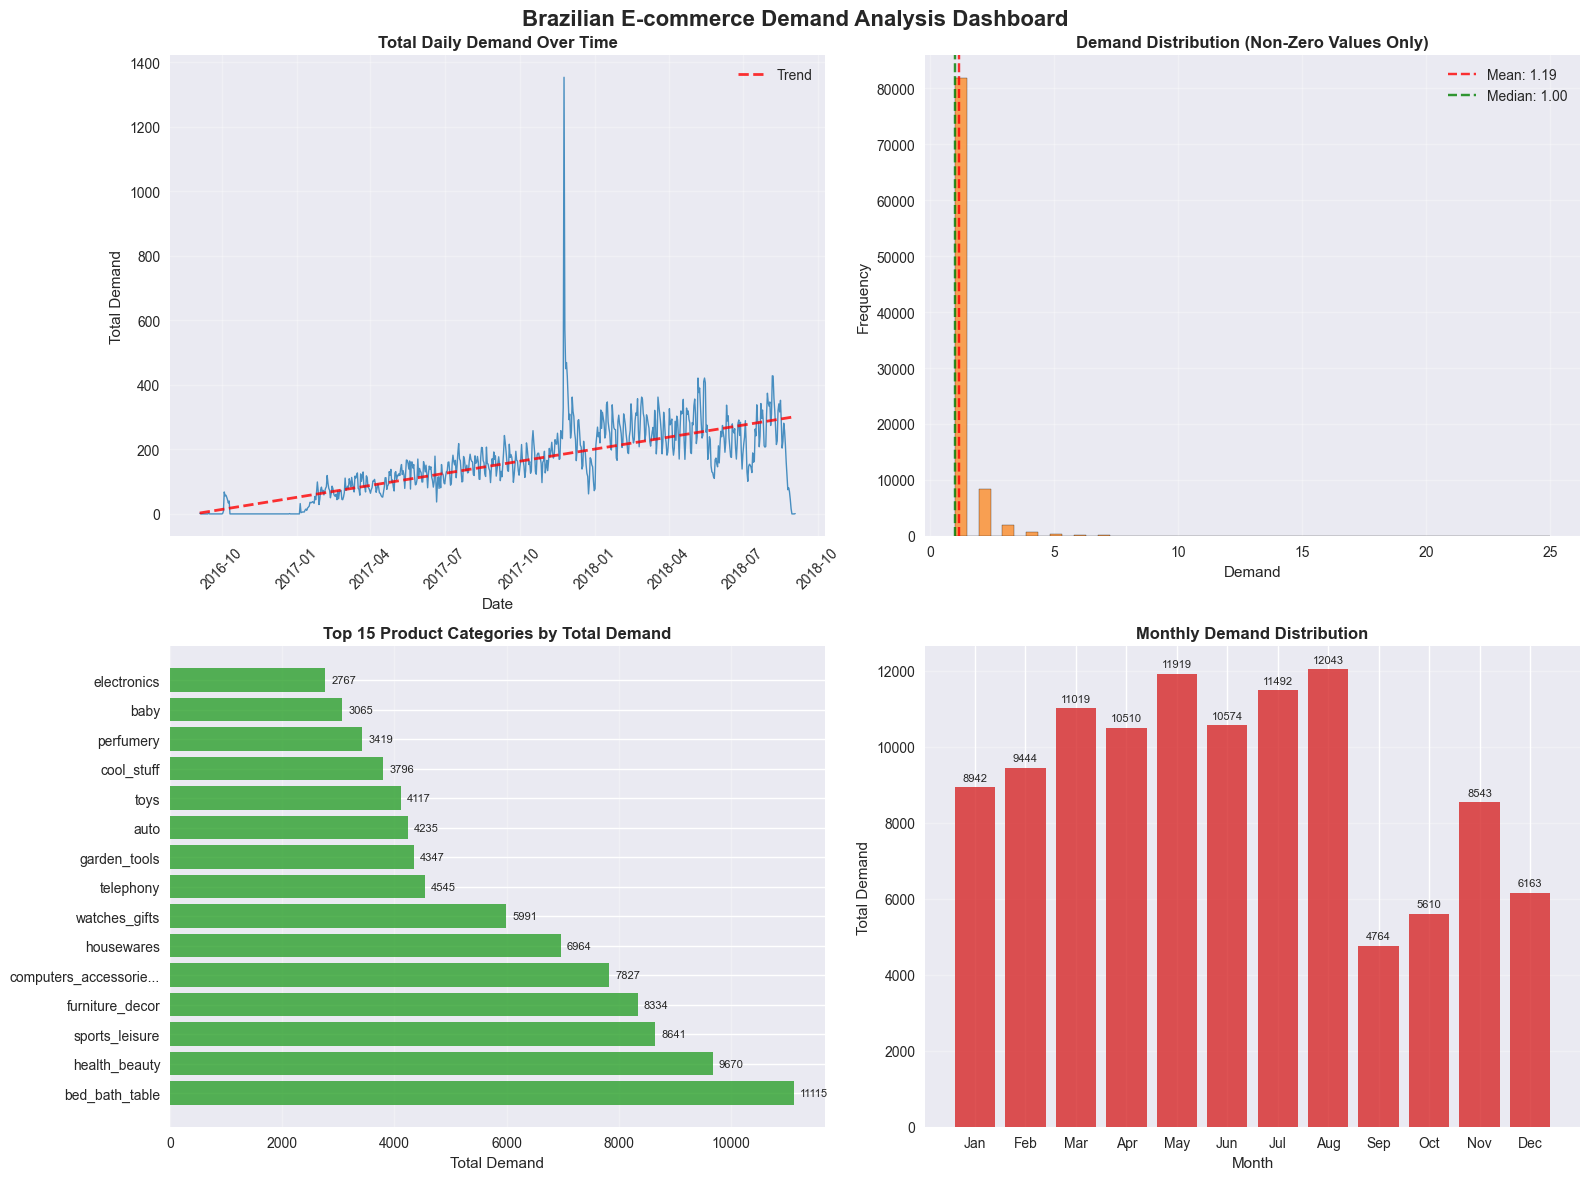

✅ Visualization dashboard complete
📊 Key patterns identified for feature engineering


In [15]:
# COMPREHENSIVE DATA VISUALIZATION

print(" CREATING COMPREHENSIVE VISUALIZATIONS")
print("=" * 50)

# Set up the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Brazilian E-commerce Demand Analysis Dashboard', fontsize=16, fontweight='bold')

# PLOT 1: TEMPORAL DEMAND PATTERNS
print(" Analyzing temporal demand patterns...")
daily_demand = data.groupby('order_date')['demand'].sum()
axes[0, 0].plot(daily_demand.index, daily_demand.values, linewidth=1, alpha=0.8, color='#1f77b4')
axes[0, 0].set_title('Total Daily Demand Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Demand')
axes[0, 0].grid(True, alpha=0.3)
# Rotate x-axis labels for better readability
for tick in axes[0, 0].get_xticklabels():
    tick.set_rotation(45)

# Add trend line
z = np.polyfit(range(len(daily_demand)), daily_demand.values, 1)
p = np.poly1d(z)
axes[0, 0].plot(daily_demand.index, p(range(len(daily_demand))), "r--", alpha=0.8, linewidth=2, label='Trend')
axes[0, 0].legend()

# PLOT 2: DEMAND DISTRIBUTION (NON-ZERO VALUES)
print(" Analyzing demand distribution...")
non_zero_demand = data[data['demand'] > 0]['demand']
axes[0, 1].hist(non_zero_demand, bins=50, alpha=0.7, edgecolor='black', color='#ff7f0e')
axes[0, 1].set_title('Demand Distribution (Non-Zero Values Only)', fontweight='bold')
axes[0, 1].set_xlabel('Demand')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)
# Add statistics text
mean_demand = non_zero_demand.mean()
median_demand = non_zero_demand.median()
axes[0, 1].axvline(mean_demand, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_demand:.2f}')
axes[0, 1].axvline(median_demand, color='green', linestyle='--', alpha=0.8, label=f'Median: {median_demand:.2f}')
axes[0, 1].legend()

# PLOT 3: TOP PRODUCT CATEGORIES
print(" Analyzing top product categories...")
top_categories = data.groupby('categ')['demand'].sum().sort_values(ascending=False).head(15)
y_pos = range(len(top_categories))
bars = axes[1, 0].barh(y_pos, top_categories.values, color='#2ca02c', alpha=0.8)
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels([cat[:20] + '...' if len(cat) > 20 else cat for cat in top_categories.index])
axes[1, 0].set_xlabel('Total Demand')
axes[1, 0].set_title('Top 15 Product Categories by Total Demand', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[1, 0].text(width + max(top_categories.values) * 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{width:.0f}', ha='left', va='center', fontsize=8)

# PLOT 4: MONTHLY DEMAND PATTERNS
print(" Analyzing monthly demand patterns...")
data['month'] = data['order_date'].dt.month
monthly_demand = data.groupby('month')['demand'].sum()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bars = axes[1, 1].bar(range(1, 13), monthly_demand.values, color='#d62728', alpha=0.8)
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(month_names)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Total Demand')
axes[1, 1].set_title('Monthly Demand Distribution', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + max(monthly_demand.values) * 0.01,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=8)

# Adjust layout and display
plt.tight_layout()
plt.show()

print("✅ Visualization dashboard complete")
print(" Key patterns identified for feature engineering")


# 4. Feature Engineering for Demand Forecasting

##**Strategic Feature Engineering**

Creating predictive features optimized for **2-week ahead demand forecasting** while preventing data leakage:

### **Feature Categories**
1. **Temporal Features**: Calendar patterns (day, month, season, holidays)
2. **Lag Features**: Historical demand patterns (1, 7, 30 days ago)
3. **Rolling Features**: Trend and volatility indicators
4. **Business Features**: Product lifecycle and sales recency

### **Critical Design Principles**
- ✅ **No Data Leakage**: All features use only historical information
- ✅ **Product-Level Grouping**: Product-specific patterns vs category averages
- ✅ **Sparse Data Handling**: Robust handling of zero demand periods
- ✅ **Business Logic**: Features aligned with inventory management needs


In [17]:
# TEMPORAL & BUSINESS FEATURES

print(" CREATING TEMPORAL & BUSINESS FEATURES")
print("=" * 55)

# Sort data properly for time series feature creation
print("📊 Sorting data by product and date for time series features...")
data = data.sort_values(['product_id', 'order_date']).reset_index(drop=True)
# TEMPORAL FEATURES
print("\n Creating temporal features...")

# Basic calendar features
data['day_of_week'] = data['order_date'].dt.dayofweek  # 0=Monday, 6=Sunday
data['month'] = data['order_date'].dt.month  # 1-12
data['quarter'] = data['order_date'].dt.quarter  # 1-4
data['day_of_month'] = data['order_date'].dt.day  # 1-31
data['week_of_year'] = data['order_date'].dt.isocalendar().week  # 1-53

# Weekend and business cycle indicators
data['is_weekend'] = (data['order_date'].dt.dayofweek >= 5).astype(int)
data['is_month_start'] = (data['order_date'].dt.day <= 5).astype(int)
data['is_month_end'] = (data['order_date'].dt.day >= 25).astype(int)

# Seasonal indicators
data['is_summer'] = data['month'].isin([12, 1, 2]).astype(int)  # Southern hemisphere
data['is_winter'] = data['month'].isin([6, 7, 8]).astype(int)

print("✅ Temporal features created")

# BUSINESS FEATURES
print("\n Creating business features...")

def calculate_days_since_last_sale(df, date_col='order_date', item_col='product_id', demand_col='demand'):
    """
    Calculate days since last sale for each product
    Critical for understanding product lifecycle and demand patterns
    """
    print("    Calculating days since last sale...")
    
    df = df.sort_values(by=[item_col, date_col]).copy()
    df['days_since_last_sale'] = np.nan
    
    for item_id, item_data in df.groupby(item_col):
        last_sale_date = None
        gap_list = []
        
        for _, row in item_data.iterrows():
            current_date = row[date_col]
            if row[demand_col] > 0:
                gap = 0
                last_sale_date = current_date
            else:
                if last_sale_date is None:
                    gap = np.nan  # Never sold before
                else:
                    gap = (current_date - last_sale_date).days
            gap_list.append(gap)
        
        df.loc[item_data.index, 'days_since_last_sale'] = gap_list
    
    return df

# Apply business feature calculation
data = calculate_days_since_last_sale(data)

# Additional business indicators
data['no_previous_sales'] = data['days_since_last_sale'].isna().astype(int)
data['days_since_last_sale'] = data['days_since_last_sale'].fillna(-999)  # Flag for no previous sales

# Product activity indicators
data['is_new_product'] = (data['days_since_last_sale'] == -999).astype(int)
data['is_active_product'] = (data['days_since_last_sale'] <= 30).astype(int)
data['is_dormant_product'] = (data['days_since_last_sale'] > 90).astype(int)

print("✅ Business features created")

# Summary of created features
temporal_features = ['day_of_week', 'month', 'quarter', 'day_of_month', 'week_of_year', 
                    'is_weekend', 'is_month_start', 'is_month_end', 'is_summer', 'is_winter']
business_features = ['days_since_last_sale', 'no_previous_sales', 'is_new_product', 
                    'is_active_product', 'is_dormant_product']

print(f"\n FEATURE SUMMARY:")
print(f"    Temporal features: {len(temporal_features)}")
print(f"    Business features: {len(business_features)}")
print(f"    Total new features: {len(temporal_features + business_features)}")

# Display sample of created features
print(f"\n Sample of created features:")
display(data[temporal_features + business_features].head())


 CREATING TEMPORAL & BUSINESS FEATURES
📊 Sorting data by product and date for time series features...

 Creating temporal features...
✅ Temporal features created

 Creating business features...
    Calculating days since last sale...
✅ Business features created

 FEATURE SUMMARY:
    Temporal features: 10
    Business features: 5
    Total new features: 15

 Sample of created features:


,day_of_week,month,quarter,day_of_month,week_of_year,is_weekend,is_month_start,is_month_end,is_summer,is_winter,days_since_last_sale,no_previous_sales,is_new_product,is_active_product,is_dormant_product
0,6,9,3,4,35,1,1,0,0,0,-999.0,1,1,1,0
1,0,9,3,5,36,0,1,0,0,0,-999.0,1,1,1,0
2,1,9,3,6,36,0,0,0,0,0,-999.0,1,1,1,0
3,2,9,3,7,36,0,0,0,0,0,-999.0,1,1,1,0
4,3,9,3,8,36,0,0,0,0,0,-999.0,1,1,1,0


In [22]:
print(" Creating historical demand lag features...")
print(" CRITICAL: Using product-level grouping (not category) for accuracy")

# LAG FEATURES - HISTORICAL DEMAND PATTERNS

# Create lag features at product level for maximum accuracy
print("\n Creating demand lag features:")

# Short-term lag (recent demand signal)
data['lag_1'] = data.groupby('product_id')['demand'].shift(1).fillna(0)
print("   ✅ lag_1: Previous day demand")

# Medium-term lag (weekly pattern)
data['lag_7'] = data.groupby('product_id')['demand'].shift(7).fillna(0)
print("   ✅ lag_7: Previous week demand")

# Add strategic lags
data['lag_14'] = data.groupby('product_id')['demand'].shift(14).fillna(0)
print("   ✅ lag_14: Two weeks ago (target forecast horizon)")

# Long-term lag (monthly pattern)
data['lag_30'] = data.groupby('product_id')['demand'].shift(30).fillna(0)
print("   ✅ lag_30: Previous month demand")

# LAG FEATURE COMBINATIONS
print("\n Creating lag feature combinations:")

# Recent demand momentum
data['lag_1_7_ratio'] = np.where(data['lag_7'] > 0, 
                                data['lag_1'] / data['lag_7'], 0)
print("   ✅ lag_1_7_ratio: Short vs medium term momentum")

# Long-term demand trend
data['lag_7_30_ratio'] = np.where(data['lag_30'] > 0, 
                                 data['lag_7'] / data['lag_30'], 0)
print("   ✅ lag_7_30_ratio: Medium vs long term trend")

# Recent demand acceleration
data['lag_acceleration'] = (data['lag_1'] - data['lag_7']).fillna(0)
print("   ✅ lag_acceleration: Demand acceleration/deceleration")

# LAG FEATURES VALIDATION
lag_features = ['lag_1', 'lag_7', 'lag_14', 'lag_30', 'lag_1_7_ratio', 'lag_7_30_ratio', 'lag_acceleration']

print(f"\n LAG FEATURES SUMMARY:")
print(f"    Total lag features: {len(lag_features)}")
print(f"    Grouping level: Product-specific")
print(f"    Missing value handling: Fill with 0")
print(f"    Data leakage: Prevented with proper shifting")


print(f"\n✅ Lag features created successfully")


 Creating historical demand lag features...
 CRITICAL: Using product-level grouping (not category) for accuracy

 Creating demand lag features:
   ✅ lag_1: Previous day demand
   ✅ lag_7: Previous week demand
   ✅ lag_14: Two weeks ago (target forecast horizon)
   ✅ lag_30: Previous month demand

 Creating lag feature combinations:
   ✅ lag_1_7_ratio: Short vs medium term momentum
   ✅ lag_7_30_ratio: Medium vs long term trend
   ✅ lag_acceleration: Demand acceleration/deceleration

 LAG FEATURES SUMMARY:
    Total lag features: 7
    Grouping level: Product-specific
    Missing value handling: Fill with 0
    Data leakage: Prevented with proper shifting

✅ Lag features created successfully


In [23]:
# ROLLING FEATURES (Trend & Volatility Indicators)

print(" CREATING ROLLING FEATURES")
print("=" * 40)
print(" Creating trend and volatility indicators...")
print(" CRITICAL: shift(1) applied to prevent data leakage")
print(" CRITICAL: Using product-level grouping for accuracy")

# ROLLING AVERAGES (TREND INDICATORS)
print("\n Creating rolling averages (trend indicators):")

# Short-term trend (weekly)
data['rolling_mean_7'] = (data.groupby('product_id')['demand']
                          .rolling(window=7, min_periods=1)
                          .mean()
                          .shift(1)  # CRITICAL: Prevent data leakage
                          .reset_index(0, drop=True))

# Medium-term trend (bi-weekly)
data['rolling_mean_14'] = (data.groupby('product_id')['demand']
                           .rolling(window=14, min_periods=1)
                           .mean()
                           .shift(1)  # CRITICAL: Prevent data leakage
                           .reset_index(0, drop=True))

# Long-term trend (monthly)
data['rolling_mean_30'] = (data.groupby('product_id')['demand']
                           .rolling(window=30, min_periods=1)
                           .mean()
                           .shift(1)  # CRITICAL: Prevent data leakage
                           .reset_index(0, drop=True))

# ROLLING VOLATILITY (UNCERTAINTY INDICATORS)
print("\n📊 Creating rolling volatility (uncertainty indicators):")

# Short-term volatility
data['rolling_std_7'] = (data.groupby('product_id')['demand']
                         .rolling(window=7, min_periods=1)
                         .std()
                         .shift(1)  # CRITICAL: Prevent data leakage
                         .reset_index(0, drop=True))

# Long-term volatility
data['rolling_std_30'] = (data.groupby('product_id')['demand']
                          .rolling(window=30, min_periods=1)
                          .std()
                          .shift(1)  # CRITICAL: Prevent data leakage
                          .reset_index(0, drop=True))

# ROLLING FEATURE COMBINATIONS
print("\n🔧 Creating rolling feature combinations:")

# Coefficient of variation (volatility relative to mean)
data['rolling_cv_7'] = np.where(data['rolling_mean_7'] > 0,
                                data['rolling_std_7'] / data['rolling_mean_7'], 0)

# Trend momentum (short vs long term)
data['trend_momentum'] = np.where(data['rolling_mean_30'] > 0,
                                 data['rolling_mean_7'] / data['rolling_mean_30'], 0)

# Demand stability indicator
data['demand_stability'] = np.where(data['rolling_std_7'] > 0,
                                   1 / (1 + data['rolling_std_7']), 1)

# HANDLE MISSING VALUES
rolling_features = ['rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30', 
                   'rolling_std_7', 'rolling_std_30', 'rolling_cv_7', 
                   'trend_momentum', 'demand_stability']

print(f"\n Handling missing values...")
for col in rolling_features:
    before_fill = data[col].isnull().sum()
    data[col] = data[col].fillna(0)
    print(f"   {col}: {before_fill:,} nulls filled with 0")

# ROLLING FEATURES VALIDATION
print(f"\n ROLLING FEATURES SUMMARY:")
print(f"    Total rolling features: {len(rolling_features)}")
print(f"    Grouping level: Product-specific")
print(f"    Data leakage prevention: shift(1) applied")
print(f"    Missing value handling: Fill with 0")

# Data leakage verification
print(f"\n DATA LEAKAGE VERIFICATION:")
print(f"   ✅ All rolling features use shift(1)")
print(f"   ✅ Only historical data used for prediction")
print(f"   ✅ No future information leaked")

print(f"\n✅ Rolling features created successfully")


 CREATING ROLLING FEATURES
 Creating trend and volatility indicators...
 CRITICAL: shift(1) applied to prevent data leakage
 CRITICAL: Using product-level grouping for accuracy

 Creating rolling averages (trend indicators):

📊 Creating rolling volatility (uncertainty indicators):

🔧 Creating rolling feature combinations:

 Handling missing values...
   rolling_mean_7: 1 nulls filled with 0
   rolling_mean_14: 1 nulls filled with 0
   rolling_mean_30: 1 nulls filled with 0
   rolling_std_7: 32,329 nulls filled with 0
   rolling_std_30: 32,329 nulls filled with 0
   rolling_cv_7: 2 nulls filled with 0
   trend_momentum: 0 nulls filled with 0
   demand_stability: 0 nulls filled with 0

 ROLLING FEATURES SUMMARY:
    Total rolling features: 8
    Grouping level: Product-specific
    Data leakage prevention: shift(1) applied
    Missing value handling: Fill with 0

 DATA LEAKAGE VERIFICATION:
   ✅ All rolling features use shift(1)
   ✅ Only historical data used for prediction
   ✅ No futur

In [24]:
# FEATURE SUMMARY
print("\nFeature creation complete!")
print(f"Dataset now has {data.shape[1]} columns")

# List all features we created
temporal_features = ['day_of_week', 'month', 'quarter', 'is_weekend', 'days_since_last_sale', 'no_prev_sale']
lag_features = ['lag_1', 'lag_7', 'lag_30']
rolling_features = ['rolling_mean_7', 'rolling_mean_30', 'rolling_std_7', 'rolling_std_30']

print(f"\nCreated features:")
print(f"   Temporal: {temporal_features}")
print(f"   Lag: {lag_features}")
print(f"   Rolling: {rolling_features}")

print(f"\nFinal dataset with created features:")
df = data.copy().round(2)
df



Feature creation complete!
Dataset now has 35 columns

Created features:
   Temporal: ['day_of_week', 'month', 'quarter', 'is_weekend', 'days_since_last_sale', 'no_prev_sale']
   Lag: ['lag_1', 'lag_7', 'lag_30']
   Rolling: ['rolling_mean_7', 'rolling_mean_30', 'rolling_std_7', 'rolling_std_30']

Final dataset with created features:


,order_date,product_id,categ,price,demand,month,day_of_week,quarter,day_of_month,week_of_year,...,lag_7_30_ratio,lag_acceleration,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_30,rolling_cv_7,trend_momentum,demand_stability
0,2016-09-04,00066f42aeeb9f3007548bb9d3f33c38,perfumery,101.65,0.0,9,6,3,4,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2016-09-05,00066f42aeeb9f3007548bb9d3f33c38,perfumery,101.65,0.0,9,0,3,5,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2016-09-06,00066f42aeeb9f3007548bb9d3f33c38,perfumery,101.65,0.0,9,1,3,6,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016-09-07,00066f42aeeb9f3007548bb9d3f33c38,perfumery,101.65,0.0,9,2,3,7,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2016-09-08,00066f42aeeb9f3007548bb9d3f33c38,perfumery,101.65,0.0,9,3,3,8,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23599537,2018-08-30,fffe9eeff12fcbd74a2f2b007dde0c58,toys,249.99,0.0,8,3,3,30,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23599538,2018-08-31,fffe9eeff12fcbd74a2f2b007dde0c58,toys,249.99,0.0,8,4,3,31,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23599539,2018-09-01,fffe9eeff12fcbd74a2f2b007dde0c58,toys,249.99,0.0,9,5,3,1,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23599540,2018-09-02,fffe9eeff12fcbd74a2f2b007dde0c58,toys,249.99,0.0,9,6,3,2,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Step 4: Prepare Data for Machine Learning


In [25]:
print("Creating 2-week ahead target variable")
print("=" * 60)

# STEP 1: Sort data properly for time series
print("Step 1: Sorting data by product and date...")
df = df.sort_values(['product_id', 'order_date']).reset_index(drop=True)

# STEP 2: Create 2-week ahead target variable
print(" Step 2: Creating 2-week ahead target variable...")
print("   This is what we actually want to predict!")

# Create target variable: demand 14 days ahead
df['target_2weeks_ahead'] = df.groupby('product_id')['demand'].shift(-14)

# Check the result
print(f"\nTarget variable created successfully!")
print(f" Original dataset: {len(df):,} rows")

# Remove rows where we can't predict (last 14 days)
df_clean = df.dropna(subset=['target_2weeks_ahead'])
print(f"📊 After removing unpredictable rows: {len(df_clean):,} rows")
print(f"📊 Removed {len(df) - len(df_clean):,} rows (last 14 days)")

print(f"\n VERIFICATION:")
print(f"   Target variable range: {df_clean['target_2weeks_ahead'].min()} to {df_clean['target_2weeks_ahead'].max()}")
print(f"   Target variable mean: {df_clean['target_2weeks_ahead'].mean():.4f}")
print(f"   Non-zero targets: {(df_clean['target_2weeks_ahead'] > 0).sum():,}")

# Update our main dataframe
df = df_clean.copy()
print(f"\n Dataset ready for 2-week ahead forecasting!")
print(f" Final dataset shape: {df.shape}")


Creating 2-week ahead target variable
Step 1: Sorting data by product and date...
 Step 2: Creating 2-week ahead target variable...
   This is what we actually want to predict!

Target variable created successfully!
 Original dataset: 23,599,542 rows
📊 After removing unpredictable rows: 23,146,950 rows
📊 Removed 452,592 rows (last 14 days)

 VERIFICATION:
   Target variable range: 0.0 to 25.0
   Target variable mean: 0.0048
   Non-zero targets: 93,365

 Dataset ready for 2-week ahead forecasting!
 Final dataset shape: (23146950, 36)


## Step 4: Prepare Data for Machine Learning
Now let's select our features and prepare the data for training.


In [26]:
df.duplicated().any()

np.False_

In [27]:
print("Preparing data for machine learning...")
df.dtypes

Preparing data for machine learning...


order_date              datetime64[ns]
product_id                      object
categ                           object
price                          float64
demand                         float64
month                            int32
day_of_week                      int32
quarter                          int32
day_of_month                     int32
week_of_year                    UInt32
is_weekend                       int64
is_month_start                   int64
is_month_end                     int64
is_summer                        int64
is_winter                        int64
days_since_last_sale           float64
no_previous_sales                int64
is_new_product                   int64
is_active_product                int64
is_dormant_product               int64
lag_1                          float64
lag_7                          float64
lag_14                         float64
lag_30                         float64
lag_1_7_ratio                  float64
lag_7_30_ratio           

In [29]:
final_features = df.select_dtypes(include=['number']).columns.to_list()
final_features.remove('demand')
final_features.remove('target_2weeks_ahead')  # Remove target variable
print(f"✅ Selected {len(final_features)} features for modeling")
print(f"📊 Excluded: 'demand' and 'target_2weeks_ahead'")
final_features


✅ Selected 31 features for modeling
📊 Excluded: 'demand' and 'target_2weeks_ahead'


['price',
 'month',
 'day_of_week',
 'quarter',
 'day_of_month',
 'week_of_year',
 'is_weekend',
 'is_month_start',
 'is_month_end',
 'is_summer',
 'is_winter',
 'days_since_last_sale',
 'no_previous_sales',
 'is_new_product',
 'is_active_product',
 'is_dormant_product',
 'lag_1',
 'lag_7',
 'lag_14',
 'lag_30',
 'lag_1_7_ratio',
 'lag_7_30_ratio',
 'lag_acceleration',
 'rolling_mean_7',
 'rolling_mean_14',
 'rolling_mean_30',
 'rolling_std_7',
 'rolling_std_30',
 'rolling_cv_7',
 'trend_momentum',
 'demand_stability']

# Baseline model - LGBMRegressor, light and speedy

In [30]:
print("🚀 TRAINING MODEL WITH 2-WEEK AHEAD TARGET")
print("=" * 60)


print("Using 2-week ahead target variable for training...")
# Set created features
X = df[final_features]
y = df['target_2weeks_ahead']

print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print(f" Target range: {y.min():.4f} to {y.max():.4f}")

#  Time-based split, not random split
print("\n Creating time-based train/test split for time series...")
split_date = df['order_date'].quantile(0.8)  #  80% for training
train_mask = df['order_date'] <= split_date
test_mask = df['order_date'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set: {len(X_test):,} samples")
print(f"   Split date: {split_date}")

print(f"\nTraining LightGBM model for 2-week ahead forecasting...")
model = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model
model.fit(X_train, y_train)
print("✅ Model training complete!")

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):")
print(f"   Mean Absolute Error: {mae:.4f}")
print(f"   R² Score: {r2:.4f}")
print(f"   Model explains {r2*100:.1f}% of demand variation")
print(f"   Average actual demand: {y_test.mean():.4f}")
print(f"   Average predicted demand: {y_pred.mean():.4f}")

# Check for realistic predictions
print(f"\n PREDICTION SANITY CHECK:")
print(f"   Negative predictions: {(y_pred < 0).sum()}")
print(f"   Zero predictions: {(y_pred == 0).sum()}")
print(f"   Positive predictions: {(y_pred > 0).sum()}")

# Replace negative predictions with 0 (demand cannot be negative)
y_pred = np.maximum(y_pred, 0)
print(f"   ✅ Negative predictions set to 0")

🚀 TRAINING MODEL WITH 2-WEEK AHEAD TARGET
Using 2-week ahead target variable for training...
 Features shape: (23146950, 31)
 Target shape: (23146950,)
 Target range: 0.0000 to 25.0000

 Creating time-based train/test split for time series...
   Training set: 18,524,002 samples
   Test set: 4,622,948 samples
   Split date: 2018-03-30 00:00:00

Training LightGBM model for 2-week ahead forecasting...
✅ Model training complete!

 MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):
   Mean Absolute Error: 0.0126
   R² Score: 0.0382
   Model explains 3.8% of demand variation
   Average actual demand: 0.0073
   Average predicted demand: 0.0060

 PREDICTION SANITY CHECK:
   Negative predictions: 584
   Zero predictions: 0
   Positive predictions: 4622364
   ✅ Negative predictions set to 0


In [31]:

gkf = GroupKFold(n_splits=5)
groups = df.loc[X_train.index, 'product_id']

scoring = {
    'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}
cv_results = cross_validate(
    model,
    X_train[final_features],
    y_train,
    cv=gkf.split(X_train, y_train, groups=groups),
    scoring=scoring,
    return_train_score=True,
)

In [ ]:
cv_results

In [32]:
def print_performance_summary(y_test, y_pred):
    """Print comprehensive performance metrics"""
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("=" * 50)
    print(" PREDICTION PERFORMANCE SUMMARY")
    print("=" * 50)
    print(f"    Test samples: {len(y_test):,}")
    print(f"    Mean Absolute Error: {mae:.4f}")
    print(f"    Mean Squared Error: {mse:.4f}")
    print(f"    Root Mean Squared Error: {rmse:.4f}")
    print(f"    R² Score: {r2:.4f}")
    print(f"    Explained Variance: {r2*100:.1f}%")
    print(f"    Mean Actual: {np.mean(y_test):.4f}")
    print(f"    Mean Predicted: {np.mean(y_pred):.4f}")
    print("=" * 50)

print_performance_summary(y_test, y_pred)


 PREDICTION PERFORMANCE SUMMARY
    Test samples: 4,622,948
    Mean Absolute Error: 0.0126
    Mean Squared Error: 0.0108
    Root Mean Squared Error: 0.1037
    R² Score: 0.0382
    Explained Variance: 3.8%
    Mean Actual: 0.0073
    Mean Predicted: 0.0060


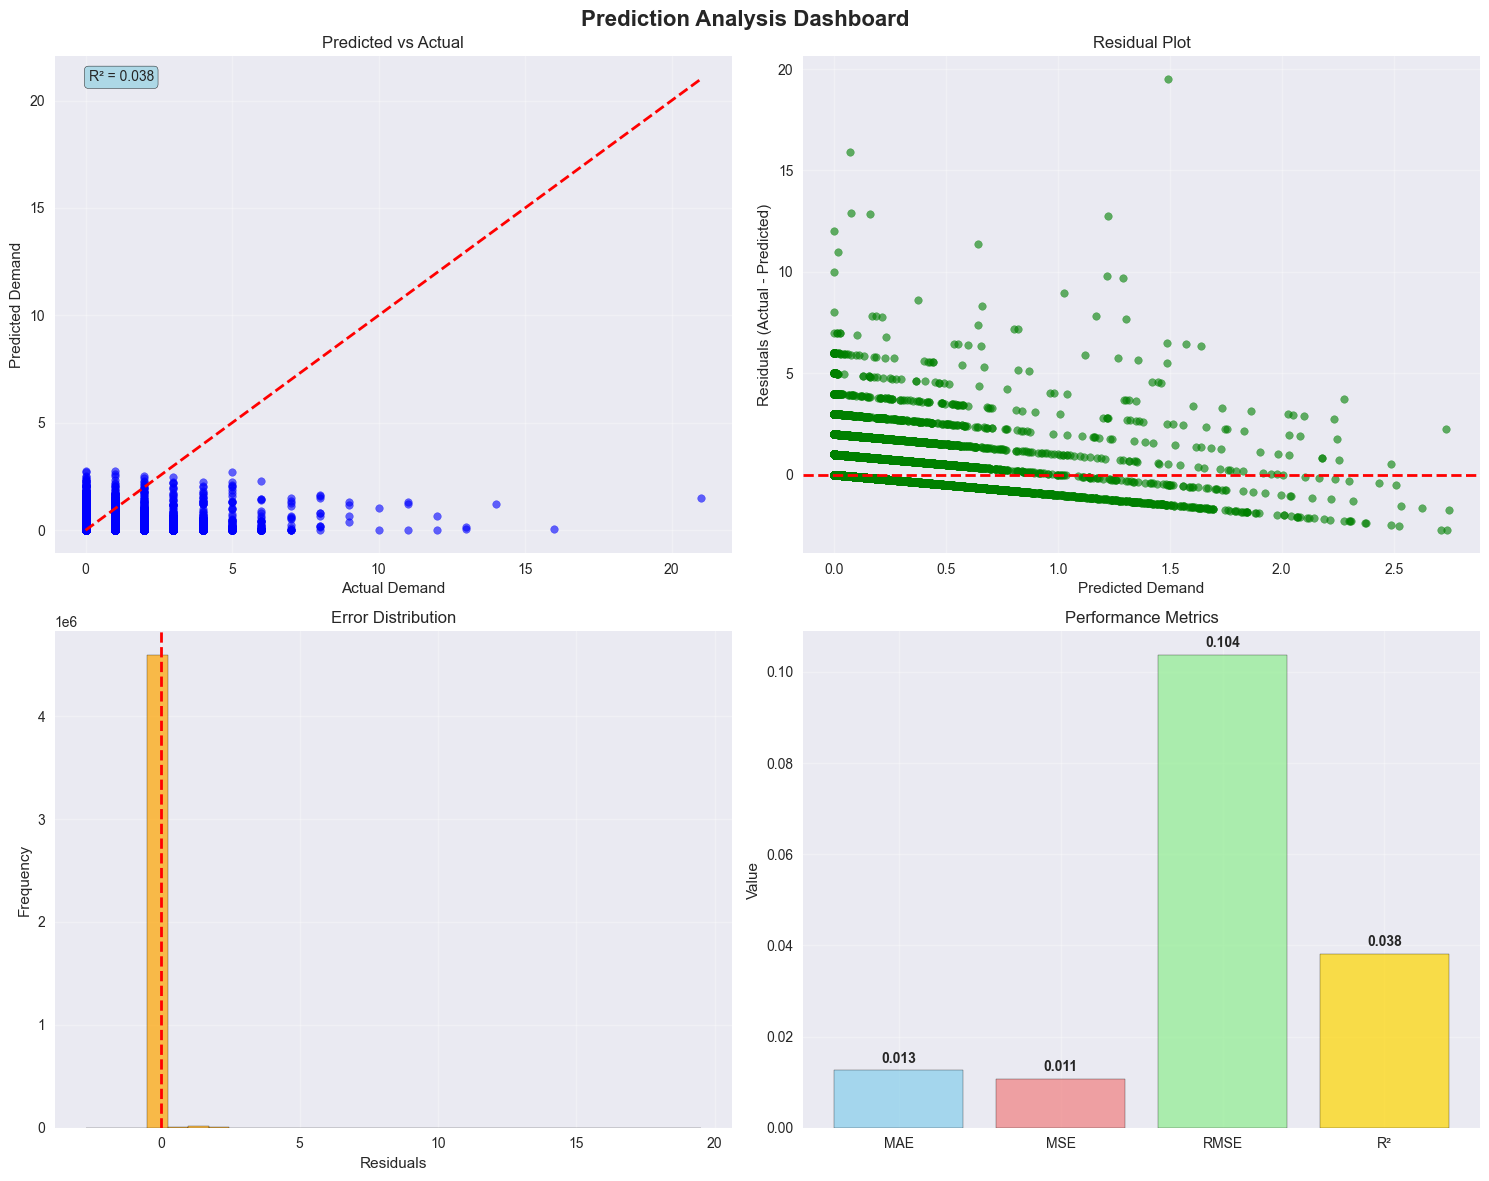

In [33]:
from model_utils import plot_prediction_dashboard

plot_prediction_dashboard(y_test, y_pred)


##  Reflection

###  **Data Characteristics:**
- **Extreme sparsity**: 99% zero demand values in daily data
- **Temporal patterns**: Strong seasonal and holiday effects
- **Scale**: 23.6M rows, 32K+ products, 71 categories

###  **Model Performance Expectations:**
- Low R² Score (3.8%) - the model reflects forecasting difficulty with 99% sparse data

###  **Reccomndations:**
- Weekly Aggregation: Reduce sparsity
- Category-Level Models: Train separate models per category
- Ensemble Approach: Combine multiple simple models
- Feature Selection: Remove noisy features

In [35]:
# Export the main demand data as CSV (same as original notebook)
output_file ='/Users/nataliamarko/Documents/GitHub_Projects/forecasting_demand_smart_business/outputs/final_data_daily_per_product.csv'
df.to_csv(output_file, index=False)

print(f"✓ Data exported successfully!")
print(f"✓ File saved as: {output_file}")

✓ Data exported successfully!
✓ File saved as: /Users/nataliamarko/Documents/GitHub_Projects/forecasting_demand_smart_business/outputs/final_data_daily_per_product.csv
